In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
# Get the stock quote
df = yf.Ticker('^IXIC').history(period='Max')

In [30]:
df = yf.download('^IXIC', start = '1971-02-05', end='2021-01-15', progress = False)

In [31]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...
2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7223660000
2021-01-11,13048.780273,13138.269531,12999.509766,13036.429688,13036.429688,6876420000
2021-01-12,13062.059570,13105.040039,12963.919922,13072.429688,13072.429688,7181380000


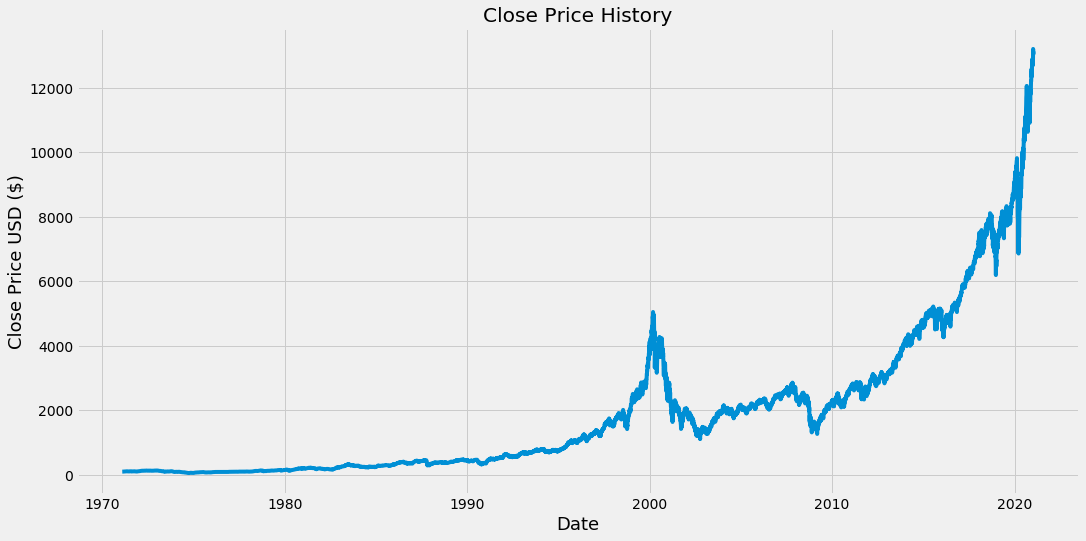

In [15]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [16]:
# Create new dataframe with only the 'Close' column
data = df.filter(['Close'])

In [17]:
# Convert dataframe to numpy array
dataset = data.values

In [18]:
# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * 0.8 )

training_data_len

10077

In [19]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(len(scaled_data))
scaled_data

12596


array([[0.00343269],
       [0.00349659],
       [0.0034905 ],
       ...,
       [0.98740782],
       [0.99014606],
       [0.99444515]])

In [20]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

# Takes the first 60 values for x train and y train is the 61st value
for i in range(60 , len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00343269, 0.00349659, 0.0034905 , 0.00348518, 0.00354298,
       0.00358862, 0.00359927, 0.00356504, 0.0035407 , 0.00348594,
       0.00340835, 0.0034114 , 0.00348137, 0.00352625, 0.00353462,
       0.00356808, 0.00357265, 0.00359014, 0.00364415, 0.00366088,
       0.00375444, 0.00376813, 0.00374759, 0.00375672, 0.00377497,
       0.00382289, 0.0038556 , 0.00385104, 0.00387994, 0.00387157,
       0.00384115, 0.00382137, 0.00379019, 0.00378258, 0.00381833,
       0.00382822, 0.00384647, 0.00388679, 0.00391493, 0.00395448,
       0.00397806, 0.00400772, 0.00404576, 0.0040701 , 0.00410737,
       0.00410585, 0.00412334, 0.00416974, 0.00419027, 0.00420549,
       0.00415757, 0.00415681, 0.00419256, 0.0042458 , 0.00427927,
       0.00432186, 0.00437358, 0.00438043, 0.00436826, 0.004296  ])]
[0.004327947030019048]



In [21]:
# Convert x_train and y_train to numpy arrays to train LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [22]:
# Reshape the data because LSTM takes input as 3D and our data is in 2D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(10017, 60, 1)

In [24]:
# give best model loop
rmse = 100
while rmse > 50:
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    # Create the testing data set
    # Create a new array containing scaled values from 552-60 to 765
    test_data = scaled_data[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt( np.mean( predictions - y_test )**2 )
    print(rmse)


10017/10017 [==============================] - 172s 17ms/step - loss: 1.6037e-04
84.10295785235337
10017/10017 [==============================] - 169s 17ms/step - loss: 1.5586e-04
166.70485055763695
10017/10017 [==============================] - 171s 17ms/step - loss: 1.5927e-04
73.23156277912862
10017/10017 [==============================] - 169s 17ms/step - loss: 1.5868e-04
27.35693902125099


### TEST

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

10241/10241 [==============================] - 159s 15ms/step - loss: 1.7590e-04


In [34]:
# Create the testing data set
# Create a new array containing scaled values from 552-60 to 765
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [35]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [42]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [37]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [46]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

5.026348793992718

### TEST

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


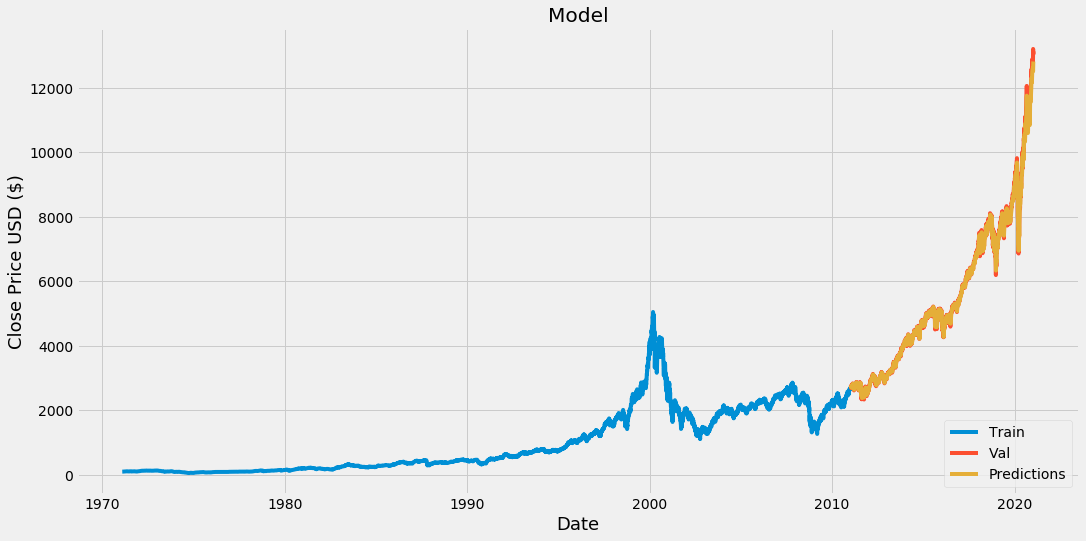

In [25]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [26]:
# Show the valid and the predicted prices
valid['RMSE'] = (valid['Predictions'] - valid['Close'])**2
valid['Variance %'] = ((valid['Close'] - valid['Predictions'])/valid['Close']) * 100
valid

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,Predictions,RMSE,Variance %
Date,,,,
2011-01-11,2716.830078,2704.395996,154.606396,0.457669
2011-01-12,2737.330078,2708.973633,804.087991,1.035916
2011-01-13,2735.290039,2719.550781,247.724236,0.575415
2011-01-14,2755.300049,2727.101318,795.168400,1.023436
2011-01-18,2765.850098,2738.337402,756.948403,0.994728
...,...,...,...,...
2021-01-07,13067.480469,12511.214844,309431.445557,4.256870
2021-01-08,13201.980469,12628.518555,328858.566880,4.343757
2021-01-11,13036.429688,12779.819336,65848.872529,1.968410


In [27]:
# Get the quote
new_df = df.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[12830.964]]


In [38]:
df1['Close'] = yf.download('^IXIC', start = '2021-01-14', end='2021-01-15', progress = False)
df1['Close']

Date
2021-01-14    13174.75
Name: Close, dtype: float64

In [42]:
print(f"Actual Closing Price ($): {round(df1['Close'][0],1)}")
print(f"Predicted Closing Price ($): {round(pred_price[0][0],1)}")
print(f"Variance: {round(((pred_price[0][0] - df1['Close'][0]) / pred_price[0][0])*100, 2)} %")

Actual Closing Price ($): 13174.8
Predicted Closing Price ($): 12831.0
Variance: -2.68 %


In [43]:
((pred_price - df1['Close'][0]) / pred_price)*100

array([[-2.6793475]], dtype=float32)

In [44]:
(pred_price - df1['Close'][0])

array([[-343.78613]], dtype=float32)